TUTORIAL 2 : NPT Lennard-Jones fluid
====================================

Original authors: Andrey V. Brukhno (andrey.brukhno{at}stfc.ac.uk), James Grant (r.j.grant{at}bath.ac.uk), and John Purton (john.purton{at}stfc.ac.uk)

Modified to use dlmontepython by Joe Manning (joseph.manning{at}manchester.ac.uk)

Introduction
------------

In the NpT ensemble number of particles, pressure and temperature (*N,p,T*) are kept constant, which implies that apart from the particle moves the volume is also allowed to vary.
That is, an additional MC move, uniformly sampling the volume, is attempted with the acceptance probability:

$$ P_{acc}([r_1,V_1] \rightarrow [r_2,V_2]) = \min(1, \exp \{- \beta [U(r_2) - U(r_1) + p_{ext}(V_{2}-V_{1}) - N \beta^{-1} \ln(V_{2} / V_{1}) ] \} ) $$
where $p_{ext}$ is the external pressure. The particle coordinates are assumed to be scaled accordingly.

NOTE: The last term under the exponent needs to be modified in the cases where, for example, linear dimensions of the (cubic) cell or $\ln(V)$ are directly sampled instead of volume (keywords **linear** and **log** respectively).

In order to proceed to NpT simulation, we will modify a copy of CONTROL file that we used in Tutorial 1 for NVT simulation, wherein we need to introduce the directives specifying the volume move and the accumulation of additional statistics. 

### Setting up a CONTROL file with dlmontepython
Last time we walked through building a control file step by step. This time we'll make it a bit faster! Note, we'll use identical input files from the previous tutorial, so feel free to look back and copy/paste or rebuild them from Tutorial 1.

The control file: 
```
   NPT simulation of Lennard-Jones fluid
   use ortho
   finish
   seeds 12 34 56 78               # Seed RNG seeds explicitly to the default
   nbrlist auto                    # Use a neighbour list to speed up 
                                   # energy calculations
   maxnonbondnbrs 512              # Maximum number of neighbours in neighbour list
   temperature     1.4283461511745 # Corresponds to T*=1.1876; 
                                   # T(in K) = T* / BOLTZMAN 
   pressure        0.0179123655568
   steps          110000           # Number of moves to perform in simulation
   equilibration   10000           # Equilibration period: statistics 
                                   #are gathered after this period
   print           10000           # Print statistics every 'print' moves
   stack           10000           # Size of blocks for block averaging to obtain statistics
   sample coord    10000           # How often to print configurations to ARCHIVE.000
   sample volume 1 1.0             # sample volume every V-step, with the bin size of 1 A^3
   yamldata        1000            # collect YAML stats every 1000 move

   revconformat  dlmonte           # REVCON file is in DL_MONTE CONFIG format
   archiveformat dlpoly4           # ARCHIVE.000/HISTORY.000/TRAJECTORY.000 format 
                                   # In this case: HISTORY.000 in DLPOLY4 style
   move atom 1 512                 # Move atoms with a weight of 512
   LJ core 
   move volume cubic linear 1      # Move volume, box is cubic, 
                                   # linear scaling with a weight of 1
   start
```

The directive to invoke volume moves is **move volume**. The parameters to specify in the present tutorial are **cubic**, **linear** and **1** for the weight of volume moves among other MC steps (see the manual for further details). Note that the weight of atom moves has been set to 512 (see **move atom** directive).
Volume moves are more computationally intensive than single atom moves, so the *rule of thumb* is to attempt one volume move each time every atom has been attempted to move (so called "pass" or "sweep" through the system).

In [8]:
from dlmontepython.htk.sources import dlcontrol, dlmove


useblock = dlcontrol.UseBlock(use_statements={'ortho': None)

moves = [
    dlmove.AtomMove(pfreq=512, movers = [{"id": 'LJ core'}]),
    dlmove.VolumeCubicMove(pfreq=1, sampling='linear')
]

samples = {
    'coords': {'nfreq': 10000},
    'volume': {'binsize': 1, 'nfreq': 1}
    
}

mainblock = dlcontrol.MainBlock(
    statements={
        'seeds': {'seed0': 12, 'seed1': 34, 'seed2': 56, 'seed3': 78},
        'nbrlist': 'auto',
        'maxnonbondnbrs': 512,
        'temperature': 1.4283461511745,
        'pressure': 0.0179123655568,
        'steps': 110000,
        'equilibration': 10000,
        'print': 10000,
        'stack': 10000,
        'yamldata': 1000,
        'revconformat': 'dlmonte',
        'archiveformat': 'dlpoly4'
    },
    samples=samples,
    moves=moves
)

control = dlcontrol.CONTROL(
    title='NPT example',
    use_block=useblock,
    main_block=mainblock
)
print(control)

NPT example
use ortho 
finish use-block
seeds 12 34 56 78
nbrlist auto
maxnonbondnbrs 512
temperature 1.4283461511745
pressure 0.0179123655568
steps 110000
equilibration 10000
print 10000
stack 10000
yamldata 1000
revconformat dlmonte
archiveformat dlpoly4
sample coords 10000
sample volume 1 1
move atom 1 512
LJ core
move volume cubic linear 1
start simulation


In [11]:
import os
try:
    os.mkdir('./tutorial_2_simulation')
except FileExistsError:
    pass

with open('./tutorial_2_simulation/CONTROL', 'w') as f:
    f.write(str(control))

Exercise
--------

Run the simulation as before, then we'll import the volume data from the YAMLDATA file

<AxesSubplot:xlabel='timestamp'>

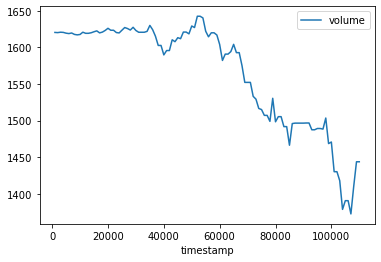

In [32]:
from dlmontepython.htk.sources import dlptfile
import pandas as pd

yaml_out = dlptfile.load_yaml('./tutorial_2_simulation/')
yaml_df = pd.DataFrame(yaml_out.data)
yaml_df = yaml_df.set_index('timestamp')
yaml_df.plot.line(y='volume')

### Questions to ask yourself:
* Would it help equilibration in the *NpT* ensemle to start the simulation after *NVT* equilibration?
* What would be the effect of changing pressure and/or temperature?
* How to *restart* the simulation for continuation?

Try to increase the pressure and run a longer simulation starting with the last saved configuration (i.e. REVCON.000). 

Alternative V-sampling schemes
------------------------------

It is also possible to conduct a random walk in the logarithm of the volume, by using the keyword **log** instead of **linear** in the directive **move volume**. This changes the way in which the move is generated: :math:`\ln(V)` is varied rather than linear dimensions of the simulation cell. This type of V-sampling is often claimed to be more efficient due to direct *scaling* of volume. 

The acceptance probability for the volume moves is now


$$
  P_{\mathrm{acc}}([\mathbf{r}_{1},V_1] \rightarrow [\mathbf{r}_2,V_2]) = \min(1, \exp \{- \beta [U(\mathbf{r}_2) - U(\mathbf{r}_1) + P_{ext}(V_{2}-V_{1}) - ( N + 1 ) \beta^{-1} \ln(V_{2} / V_{1}) ] \} )
$$

Often simulation cells will be orthorhombic (but not cubic), and more generally mono-/tri-clinic. For setting a more general volume move in these cases refer to the manual.
         
The fraction of accepted volume moves is affected by the directive **maxvolchange** setting the value of the *volume variation parameter* $\Delta_V$. In the course of an NpT simulation this value is though automatically adjusted so that the acceptance ratio converges to the targeted value that can be set in the CONTROL file by the directive **acceptatmmoveratio \<target ratio>** (0.37 by default). Additional directive **acceptvolupdate \<stride>** determines the frequency of adjustments for $\Delta_V$. 


